In [2]:
! pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-data2/plant_village",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9821 files belonging to 18 classes.


In [9]:
EPOCHS=50
CHANNELS=3

In [10]:
class_names=dataset.class_names

In [11]:
class_names

['Bacterialblight rice',
 'BlackPoint wheat',
 'Brownspot rice',
 'FusariumFootRot wheat',
 'HealthyLeaf wheat',
 'Iris yellow virus_onion',
 'LeafBlight wheat',
 'Leafsmut rice',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Stemphylium leaf blight and collectrichum leaf blight onion',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___healthy',
 'WheatBlast',
 'healthy_onion',
 'purple blotch onion']

In [12]:
len(dataset)

307

In [13]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


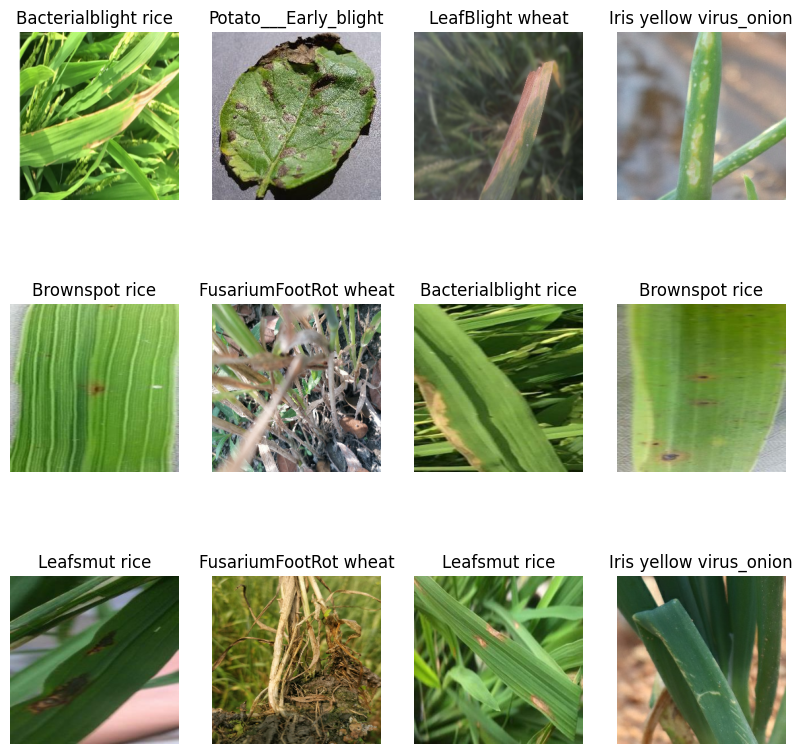

In [14]:
plt.figure(figsize=(10,10))
plt.tight_layout()

for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

Splitting into Training and Testing dataset

#training set=0.8
#validation data=0.1
#testing data=0.1

In [15]:
test_size=0.8
len(dataset)*0.8

245.60000000000002

In [16]:
train_ds=dataset.take(54)

In [17]:
len(train_ds)

54

In [18]:
test_ds=dataset.skip(54)

In [19]:
len(test_ds)

253

In [20]:
val_ds=test_ds.take(6)

In [21]:
len(val_ds)

6

In [22]:
test_ds=test_ds.skip(6)

In [23]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 247)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the model
Using Data Preprocessing


In [26]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE = 256
input_shape = (256, 256, 3)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    layers.Rescaling(1./255),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [34]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (256, 256, 3)
n_classes = 18

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    # Block 1 - Basic features
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2 - More complex features
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    # Block 3 - Higher level features
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Final feature extraction
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),

    # Classifier
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

# Use a lower learning rate with Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# More aggressive callbacks to prevent overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# dense 1000
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50


E0000 00:00:1745152351.971811      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 449ms/step - accuracy: 0.3504 - loss: 2.7795 - val_accuracy: 0.1562 - val_loss: 2.7501 - learning_rate: 5.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.5219 - loss: 1.7743 - val_accuracy: 0.2083 - val_loss: 2.7878 - learning_rate: 5.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.6366 - loss: 1.2657 - val_accuracy: 0.2031 - val_loss: 2.8789 - learning_rate: 5.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.6328 - loss: 1.2733 - val_accuracy: 0.1719 - val_loss: 2.8803 - learning_rate: 5.0000e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 431ms/step - accuracy: 0.6680 - loss: 1.1537 - val_accuracy: 0.2135 - val_loss: 4.4797 - learning_rate: 5.0000e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.6704 - loss: 1.0968 - val_accuracy: 0.1875 - val_loss: 4.5954 - learning_rate: 5.0000e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.72

In [29]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50


E0000 00:00:1745149984.183888      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_15_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745149990.692093     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 474ms/step - accuracy: 0.3079 - loss: 2.8018 - val_accuracy: 0.2083 - val_loss: 2.9002 - learning_rate: 5.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.5348 - loss: 1.8134 - val_accuracy: 0.1667 - val_loss: 3.5860 - learning_rate: 5.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.5800 - loss: 1.4482 - val_accuracy: 0.2135 - val_loss: 4.4377 - learning_rate: 5.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.6137 - loss: 1.3530 - val_accuracy: 0.2865 - val_loss: 3.3285 - learning_rate: 5.0000e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.6192 - loss: 1.1854 - val_accuracy: 0.2240 - val_loss: 3.6715 - learning_rate: 5.0000e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.6754 - loss: 1.0828 - val_accuracy: 0.3542 - val_loss: 3.1232 - learning_rate: 5.0000e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.66

In [30]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 433ms/step - accuracy: 0.7834 - loss: 0.7005 - val_accuracy: 0.7500 - val_loss: 0.9523 - learning_rate: 2.0000e-05
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - accuracy: 0.7816 - loss: 0.6953 - val_accuracy: 0.7448 - val_loss: 0.9470 - learning_rate: 2.0000e-05
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 420ms/step - accuracy: 0.8129 - loss: 0.6161 - val_accuracy: 0.7292 - val_loss: 0.9728 - learning_rate: 2.0000e-05
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.7976 - loss: 0.6442 - val_accuracy: 0.7240 - val_loss: 0.9970 - learning_rate: 2.0000e-05
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 427ms/step - accuracy: 0.7926 - loss: 0.6426 - val_accuracy: 0.7344 - val_loss: 1.0226 - learning_rate: 2.0000e-05
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.8012 - loss: 0.6272 - val_accuracy: 0.7396 - val_loss: 0.9594 - learning_rate: 2.0000e-05
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 425ms/step - acc

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl
import os

class SimpleImageDataModule(pl.LightningDataModule):
    def __init__(self, root_dir, batch_size=32, img_size=256, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        full_dataset = datasets.ImageFolder(self.root_dir, transform=self.transform)
        self.num_classes = len(full_dataset.classes)

        total_size = len(full_dataset)
        train_size = int(self.train_ratio * total_size)
        val_size = int(self.val_ratio * total_size)
        test_size = total_size - train_size - val_size

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)


ModuleNotFoundError: No module named 'pytorch_lightning'

In [60]:
from pytorch_lightning.callbacks import Callback

class AccuracyHistory(Callback):
    def __init__(self):
        self.train_acc = []
        self.val_acc = []

    def on_train_epoch_end(self, trainer, pl_module):
        acc = trainer.callback_metrics.get("train_acc")
        if acc is not None:
            self.train_acc.append(acc.cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        acc = trainer.callback_metrics.get("val_acc")
        if acc is not None:
            self.val_acc.append(acc.cpu().item())


In [11]:
import torch
import torch.nn as nn
import torchmetrics
import torch.optim as optim
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights
import pytorch_lightning as pl

class FineTuneModel(pl.LightningModule):
    def __init__(self, num_classes=18, model_version="googlenet", denselayer_size=128, dropout=0.5, l_rate=0.0005):
        super(FineTuneModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = l_rate

        self.train_acc_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        
        # Load GoogLeNet using weights API
        if model_version == "googlenet":
            self.model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT, aux_logits=True)
        else:
            self.model = models.__dict__[model_version](pretrained=True)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace final classifier
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, denselayer_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(denselayer_size, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        output = self.model(x)
        if isinstance(output, tuple) or hasattr(output, "_asdict"):  # handle namedtuple
            return output.logits  # or output[0] also works
        return output



    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.learning_rate)


ModuleNotFoundError: No module named 'torchmetrics'

In [66]:
# Use your existing dataset folder (no reorganization needed!)
data_dir = "/kaggle/input/plant-data2/plant_village"

dm = SimpleImageDataModule(root_dir=data_dir, batch_size=32)
dm.setup()

acc_hist = AccuracyHistory()

model = FineTuneModel(
    num_classes=18,
    model_version="googlenet",
    denselayer_size=128,
    dropout=0.5,
    l_rate=0.0005
)


trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices="auto",
    log_every_n_steps=10,
    callbacks=[acc_hist]
)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9280868172645569     │
│         test_loss         │    0.2191205769777298     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2191205769777298, 'test_acc': 0.9280868172645569}]

In [68]:
acc_hist.train_acc

[0.5228396654129028,
 0.7307244539260864,
 0.7721850275993347,
 0.8097177743911743,
 0.8321210145950317,
 0.8505964279174805,
 0.858888566493988,
 0.8633983135223389,
 0.8799825310707092,
 0.8745999336242676]

In [70]:
acc_hist.val_acc[0:11]

[0.0625,
 0.7488119602203369,
 0.8268839120864868,
 0.8601493835449219,
 0.8798370957374573,
 0.9008825421333313,
 0.917175829410553,
 0.9273591041564941,
 0.9300746917724609,
 0.9361846446990967,
 0.9409368634223938]

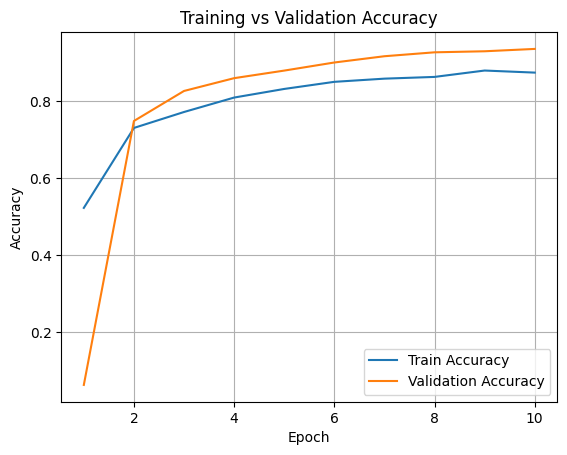

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_hist.train_acc) + 1)

plt.plot(epochs, acc_hist.train_acc, label="Train Accuracy")
plt.plot(epochs, acc_hist.val_acc[0:10], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Put model in eval mode
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions and actual labels
all_preds = []
all_labels = []

val_loader = dm.val_dataloader()

with torch.no_grad():
    for batch in val_loader:
        images, labels = batch
        images = images.to(model.device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


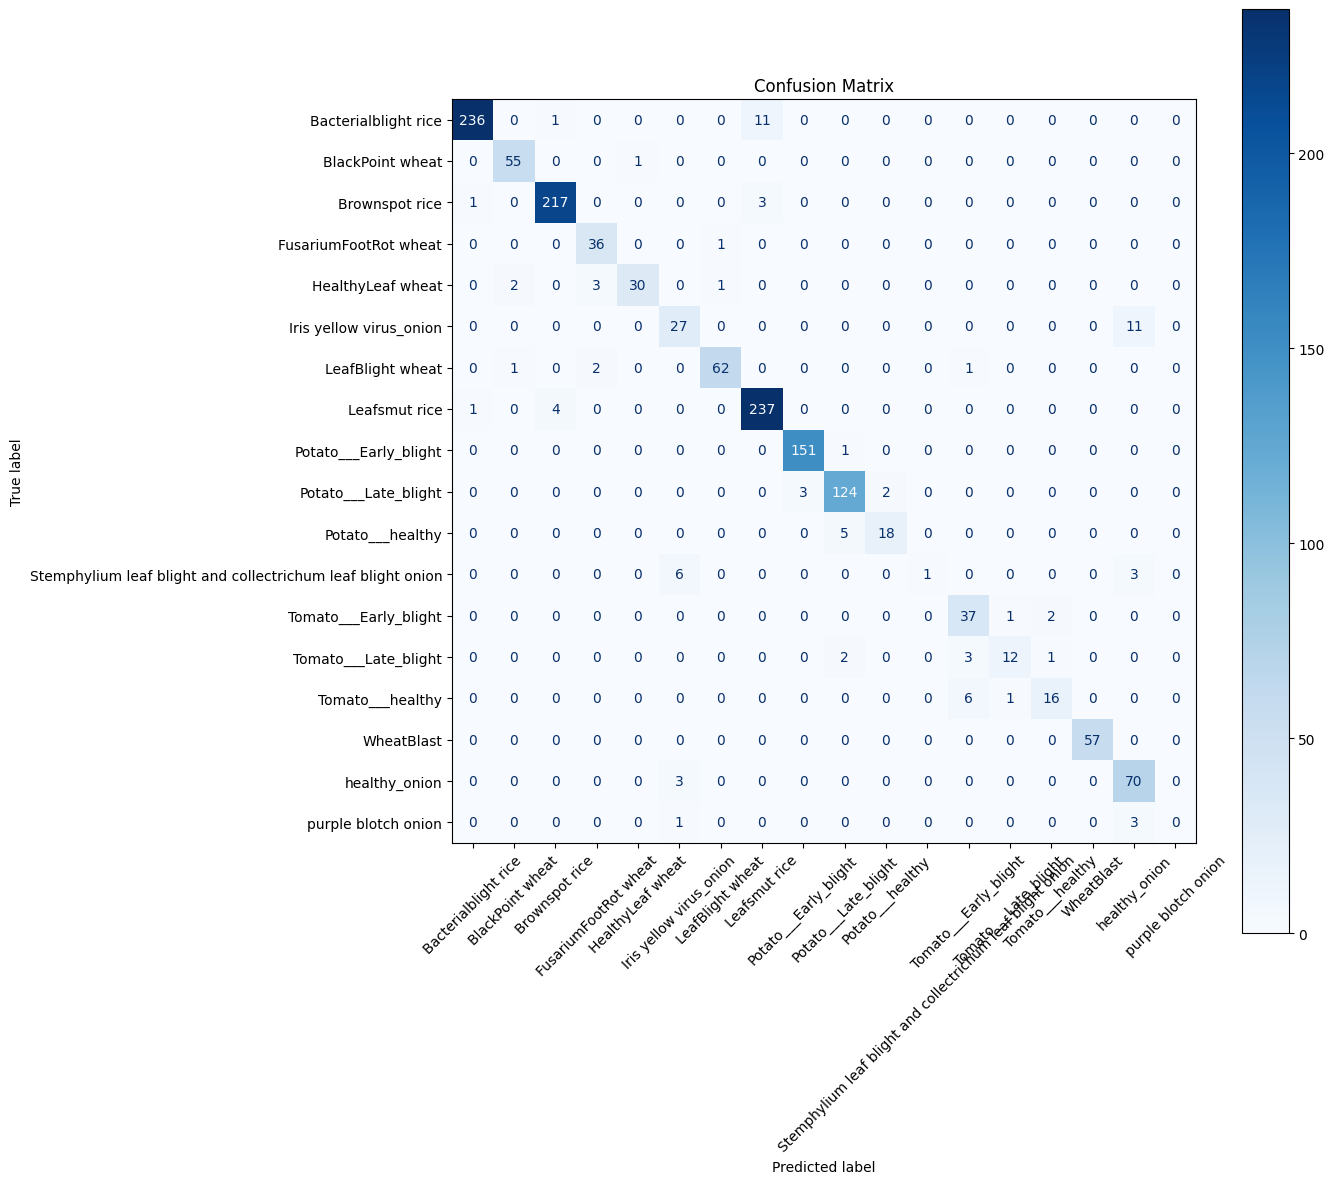

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# If class names are available
class_names = dm.train_dataset.dataset.classes  # Works with ImageFolder-based datasets

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(xticks_rotation=45, ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.show()


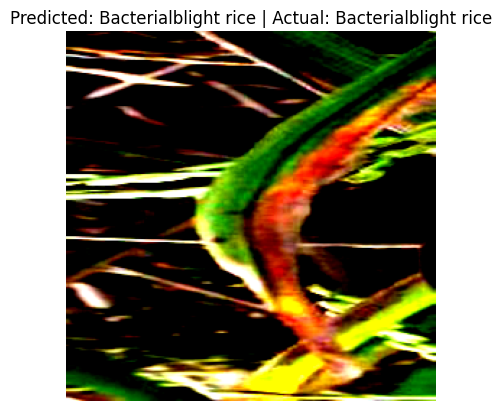

In [74]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in eval mode and on correct device
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get class names from the underlying dataset
class_names = dm.val_dataset.dataset.classes

# Get one batch from validation data
val_loader = dm.val_dataloader()
images, labels = next(iter(val_loader))

# Pick one sample
idx = 12 # You can change this to try different images
img = images[idx].unsqueeze(0).to(device)  # add batch dimension and move to device
true_label = labels[idx].item()

# Predict
with torch.no_grad():
    output = model(img)
    if hasattr(output, "logits"):
        output = output.logits
    pred_label = output.argmax(dim=1).item()

# Show image and prediction
plt.imshow(images[idx].permute(1, 2, 0).cpu())
plt.title(f"Predicted: {class_names[pred_label]} | Actual: {class_names[true_label]}")
plt.axis("off")
plt.show()


In [75]:
import pickle

with open("Disease_class.pkl", "wb") as f:
    pickle.dump(model, f)


In [2]:
import torch
import joblib

# Custom loader function to map to CPU
def cpu_loader(filename):
    return torch.load(filename, map_location=torch.device('cpu'))

# Use this custom function inside joblib
import joblib.externals.loky.backend.reduction as reduction
reduction.DEFAULT_ENV = reduction._cpu_env  # Force joblib to load on CPU

# Load the model
dodel = joblib.load("Disease_classification.pkl")


AttributeError: module 'joblib.externals.loky.backend.reduction' has no attribute '_cpu_env'

In [4]:
import torch
import joblib
import pickle

# Custom Unpickler to force CPU loading
class CPUUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=torch.device('cpu'))
        return super().find_class(module, name)

import io

def cpu_joblib_load(path):
    with open(path, 'rb') as f:
        return CPUUnpickler(f).load()

# Now load your model safely on CPU
dodel = cpu_joblib_load("Disease_classification.pkl")


In [22]:
import torch
import joblib
import pickle
import io
from PIL import Image
from torchvision import transforms


# Define the custom unpickler to load the model on CPU
class CPUUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=torch.device('cpu'))
        return super().find_class(module, name)

def cpu_joblib_load(path):
    with open(path, 'rb') as f:
        return CPUUnpickler(f).load()

# Load your saved model
state_dict = torch.load("model_weights.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()



# Load the image you want to predict
img_path = "img.JPG"
img = Image.open(img_path).convert("RGB")

# Apply the same transformation used in your DataModule
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Get prediction
with torch.no_grad():
    output = model(img_tensor)  # Make prediction
    predicted_class_idx = output.argmax(dim=1).item()  # Get the predicted class index

# Get class names from the DataModule
class_names = ['Bacterialblight rice',
 'BlackPoint wheat',
 'Brownspot rice',
 'FusariumFootRot wheat',
 'HealthyLeaf wheat',
 'Iris yellow virus_onion',
 'LeafBlight wheat',
 'Leafsmut rice',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Stemphylium leaf blight and collectrichum leaf blight onion',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___healthy',
 'WheatBlast',
 'healthy_onion',
 'purple blotch onion']  # Replace with actual class names

# Map to class label
predicted_class_name = class_names[predicted_class_idx]
print(f"Predicted class name: {predicted_class_name}")

Predicted class name: Potato___healthy


In [ ]:
import torch.nn as nn
import torchmetrics
import torch.optim as optim
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights
import pytorch_lightning as pl

class FineTuneModel(pl.LightningModule):
    def __init__(self, num_classes=18, model_version="googlenet", denselayer_size=128, dropout=0.5, l_rate=0.0005):
        super(FineTuneModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = l_rate

        self.train_acc_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc_metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
        
        # Load GoogLeNet using weights API
        if model_version == "googlenet":
            self.model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT, aux_logits=True)
        else:
            self.model = models.__dict__[model_version](pretrained=True)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace final classifier
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, denselayer_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(denselayer_size, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        output = self.model(x)
        if isinstance(output, tuple) or hasattr(output, "_asdict"):  # handle namedtuple
            return output.logits  # or output[0] also works
        return output



    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.learning_rate)


In [20]:
model = FineTuneModel(
    num_classes=18,
    model_version="googlenet",
    denselayer_size=128,
    dropout=0.5,
    l_rate=0.0005
)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\zulka/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:04<00:00, 10.8MB/s]
c:\Users\zulka\anaconda3\lib\site-packages\torchvision\models\googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [16]:
pip install torchmetrics 


     -------------------------------------- 961.5/961.5 kB 4.4 MB/s eta 0:00:00


In [18]:
pip install pytorch-lightning

     -------------------------------------- 823.0/823.0 kB 5.8 MB/s eta 0:00:00
     -------------------------------------- 443.2/443.2 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 120.8/120.8 kB ? eta 0:00:00
     ---------------------------------------- 92.9/92.9 kB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 45.2/45.2 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
